### Import Efficient 3DCNN MobileNetV2

In [1]:
import sys
sys.path.append('../Face Liveness/Models/Efficient-3DCNNs-master/models')

In [2]:
from shufflenetv2 import ShuffleNetV2
from copy import deepcopy

In [3]:
# Create an instance of the MobileNetV2 model
base_model = ShuffleNetV2(num_classes=27, sample_size=112, width_mult=1.5)

In [4]:
base_model.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): InvertedResidual(
      (banch1): Sequential(
        (0): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv3d(24, 88, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (3): BatchNorm3d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (banch2): Sequential(
        (0): Conv3d(24, 88, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(88, eps=1e-05, momentum=0.

### Load the pre-train / checkpoint

In [5]:
import torch

checkpoint_path = './jester_shufflenetv2_1.5x_RGB_16_best.pth'

# Load the checkpoint
checkpoint = torch.load(checkpoint_path)

C:\Users\andre\AppData\Local\Temp\ipykernel_17008\1195708634.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [6]:
# Remove the 'module.' prefix from the state_dict keys
new_state_dict = {}
for k, v in checkpoint['state_dict'].items():
    new_key = k.replace('module.', '')  # Remove 'module.' from key names
    new_state_dict[new_key] = v

# Load the new state_dict into your model
base_model.load_state_dict(new_state_dict, strict=False)

<All keys matched successfully>

In [7]:
# Print the original classifier structure
print("Original classifier:", base_model.classifier)

Original classifier: Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1024, out_features=27, bias=True)
)


In [8]:
# Access the last layer in the classifier to get in_features
if isinstance(base_model.classifier, torch.nn.Sequential):
    # Assuming the last layer is a Linear layer
    last_layer = base_model.classifier[-1]  # Access the last layer in the Sequential
    in_features = last_layer.in_features  # Get the number of input features
else:
    in_features = base_model.classifier.in_features  # If it's a Linear layer directly

print("Input features for the classifier:", in_features)

Input features for the classifier: 1024


### Folders

In [9]:
train_folder = '../../Dataset/CASIA-FASD/train_release'
test_folder = '../../Dataset/CASIA-FASD/test_release'

new_train_folder = '../../Dataset/CASIA-FASD/train'
validation_folder = '../../Dataset/CASIA-FASD/validation'

In [10]:
import os
import shutil
import random
from video_dataset import VideoDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [11]:
os.makedirs(new_train_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

In [12]:
identities = os.listdir(train_folder)

# split original train data --> train(80%)/validation(20%), original train data identities=20
num_val_identities = 4 #original train data * 0.2 = 4
val_identities = random.sample(identities, num_val_identities)

In [13]:
# Copy to new folders
def make_new_folder():
    for identity in identities:
        identity_path = os.path.join(train_folder, identity)

        if identity in val_identities:
            dest_folder = os.path.join(validation_folder, identity)
        else:
            dest_folder = os.path.join(new_train_folder, identity)

        os.makedirs(dest_folder, exist_ok=True)

        for video_file in os.listdir(identity_path):
            src_file = os.path.join(identity_path, video_file)
            shutil.copy(src_file, dest_folder)

In [14]:
# make_new_folder()

In [15]:
base_train_dataset = VideoDataset(train_folder)
base_train_loader = DataLoader(base_train_dataset)

In [16]:
train_dataset = VideoDataset(new_train_folder)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [17]:
validation_dataset = VideoDataset(validation_folder)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

In [18]:
test_dataset = VideoDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

##### Show sample of the first video

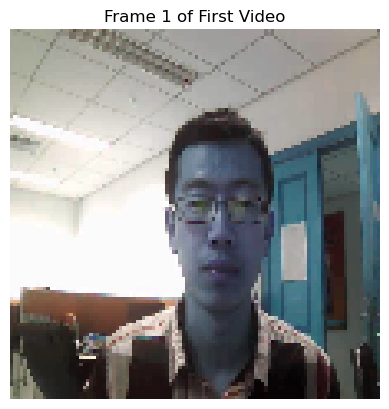

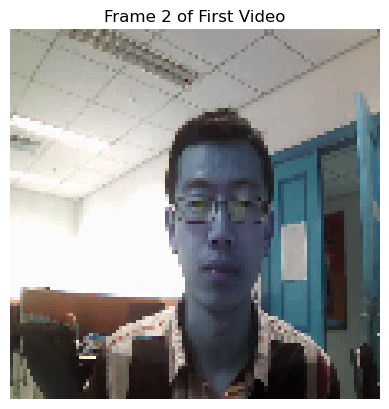

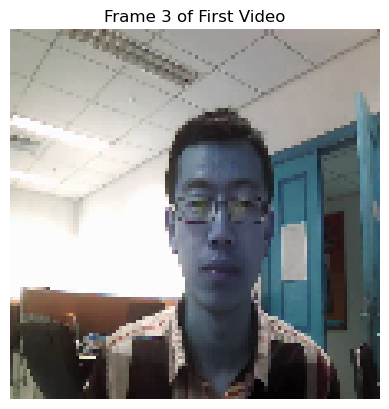

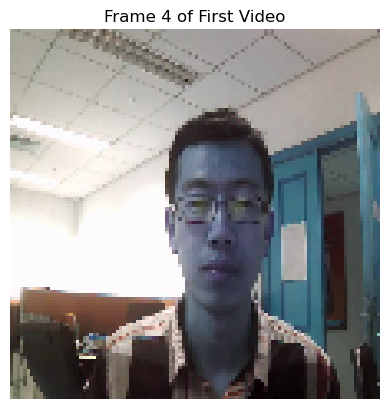

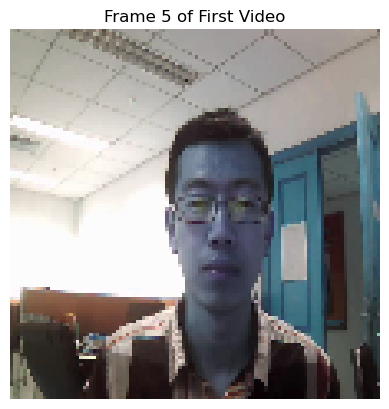

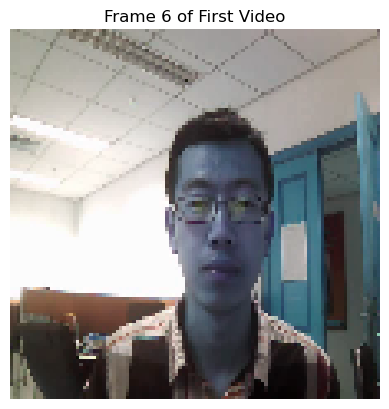

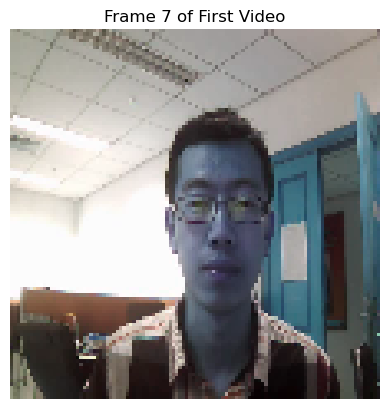

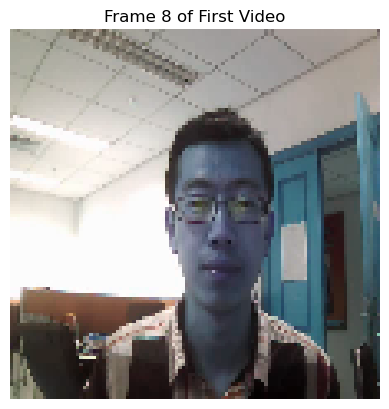

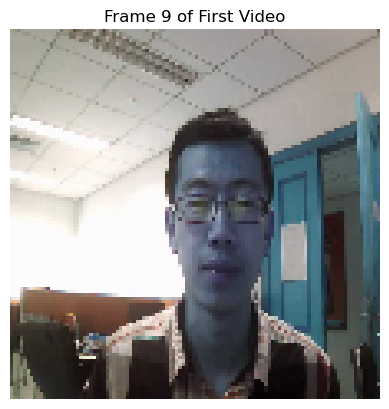

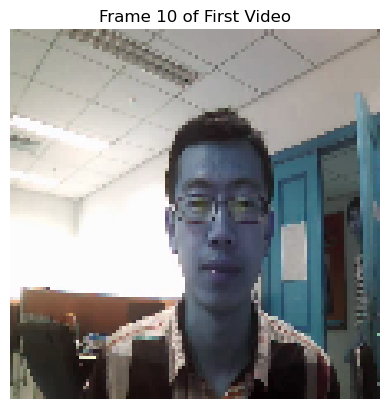

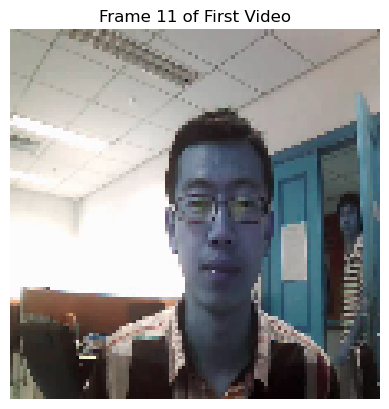

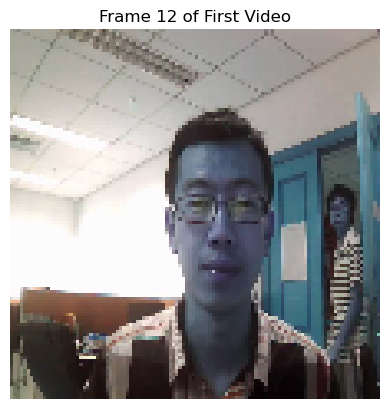

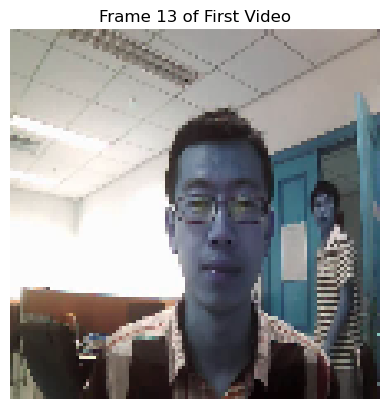

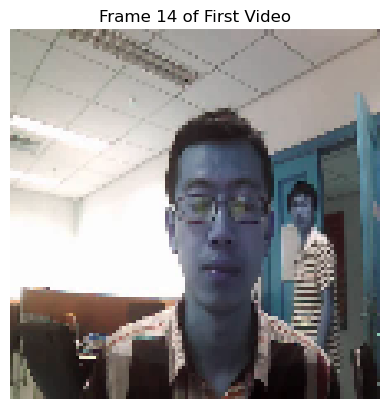

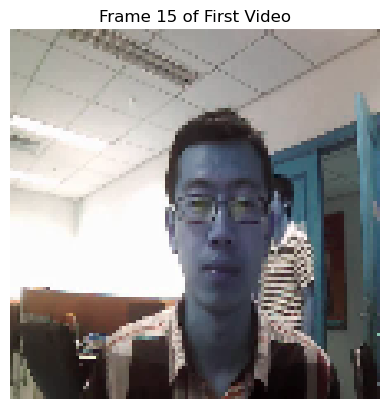

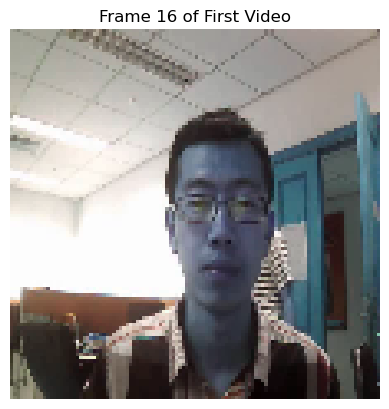

In [19]:
for frames, labels, _ in train_loader:  # Unpack frames and labels
    for i in range(frames.size(1)):  # frames.size(1) gives the number of frames in the first video
        plt.imshow(frames[0][i].permute(1, 2, 0).numpy())  # Show the i-th frame of the first video
        plt.axis('off')  # Hide axis
        plt.title(f'Frame {i + 1} of First Video')
        plt.show()
    
    break  # Exit after the first batch

#### Check data shape

In [20]:
# Check the length of the train dataset
print("Number of videos in train dataset:", len(train_dataset))
print("Number of videos in validation dataset:", len(validation_dataset))
print("Number of videos in test dataset:", len(test_dataset))

# Check the return value of the first item in the dataset
sample_frames, sample_label, _ = train_dataset[0]  # Get the first video
print("Return value for the first video (frames, label):", (sample_frames, sample_label))

# Check the shape of the frames
if isinstance(sample_frames, torch.Tensor):
    print("Shape of frames for the first video:", sample_frames.shape)
else:
    print("The first video frames are not a tensor, inspect further.")


Number of videos in train dataset: 192
Number of videos in validation dataset: 48
Number of videos in test dataset: 360
Return value for the first video (frames, label): (tensor([[[[160, 154, 137,  ..., 166, 167, 112],
          [163, 157, 161,  ..., 167, 164, 140],
          [165, 165, 165,  ..., 139, 131, 148],
          ...,
          [144, 112, 103,  ...,  17,  21,  22],
          [143, 102, 106,  ...,  14,  19,  21],
          [143, 125, 114,  ...,  14,  19,  22]],

         [[162, 156, 139,  ..., 157, 157, 100],
          [165, 158, 163,  ..., 160, 158, 131],
          [167, 167, 167,  ..., 133, 125, 140],
          ...,
          [149, 118, 108,  ...,  15,  17,  19],
          [148, 107, 111,  ...,  12,  15,  18],
          [148, 130, 119,  ...,  12,  15,  18]],

         [[146, 140, 123,  ..., 150, 151, 101],
          [149, 143, 147,  ..., 144, 141, 124],
          [151, 151, 151,  ..., 114, 108, 130],
          ...,
          [126,  94,  85,  ...,  12,  20,  20],
          [1

### Insert Data to Model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
print(device)

cuda


In [23]:
import torch.nn as nn
import torch.optim as optim

In [24]:
num_classes = 2

# Replace the classifier's Linear layer to match the number of classes
in_features = base_model.classifier[1].in_features  # Get in_features from the existing Linear layer
base_model.classifier[1] = nn.Linear(in_features, num_classes)  # Update the Linear layer with new out_features

In [25]:
base_model = base_model.to(device)

In [26]:
keep_base_model = deepcopy(base_model)

In [27]:
base_model.eval()

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv3d(3, 24, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), bias=False)
    (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (features): Sequential(
    (0): InvertedResidual(
      (banch1): Sequential(
        (0): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), groups=24, bias=False)
        (1): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv3d(24, 88, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (3): BatchNorm3d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (banch2): Sequential(
        (0): Conv3d(24, 88, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (1): BatchNorm3d(88, eps=1e-05, momentum=0.

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)

In [29]:
num_epochs = 10
patience = 3
train_losses = []

In [30]:
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()  # Set model to training mode
    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()  # Ensure model is in training mode

        # Training phase
        for i, (inputs, labels, _) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)

            # Convert inputs to float if they are not already
            if inputs.dtype != torch.float32:
                inputs = inputs.float()  # Convert to FloatTensor

            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    print("Base training complete.")

    return model, train_losses

In [31]:
# model, train_losses = train(base_model, base_train_loader, criterion, optimizer, num_epochs, device)

In [32]:
# print(train_losses)

In [33]:
# def plot_losses(name, losses):
#     plt.figure(figsize=(10, 5))
#     plt.plot(losses, label=f'{name} losses', color='blue', marker='o')
#     plt.title(f'{name} Loss Over Epochs')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.xticks(range(len(losses)))  # Set x-ticks to be the epoch numbers
#     plt.grid(True)
#     plt.legend()
#     plt.show()

In [34]:
# plot_losses('Train', train_losses)

In [35]:
from sklearn.metrics import classification_report

In [36]:
def test(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # No gradient calculation is needed during testing
        for inputs, labels, _ in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjust input dimensions if necessary

            if inputs.dtype != torch.float32:
                inputs = inputs.float()  # Convert to FloatTensor

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            test_losses.append(loss.item())  # Store the loss for later

            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses) if test_losses else 0

    print(classification_report(all_labels, all_predictions, target_names=['Genuine', 'Spoof']))
    return avg_test_loss

In [37]:
# test_loss = test(model, test_loader, criterion, device)

### Test with different learning rates

In [38]:
def fine_tune(model):
    # Define the parameter grid for learning rates
    learning_rates = [0.00001, 0.0001, 0.001]  # Adjust as needed
    num_fine_tune_epochs = 5

    best_lr = None
    best_loss = float('inf')  # Initialize with infinity to find the minimum loss
    results = {}  # Store results for each learning rate
    validation_losses = []

    keep_base_model_state_dict = model.state_dict()
    ft_model = deepcopy(model)

    for lr in learning_rates:
        ft_model.load_state_dict(keep_base_model_state_dict)
        print(f"Training with learning rate: {lr}")
        
        # Create a new instance of the optimizer for each learning rate
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, ft_model.parameters()), lr=lr)
        
        # Fine-tuning the model
        ft_model, fine_tune_losses = train(ft_model, train_loader, criterion, optimizer, num_fine_tune_epochs, device)

        # Evaluate on the validation dataset
        ft_model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():  # No gradients needed for evaluation
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.float()
                inputs = inputs.permute(0, 2, 1, 3, 4)  # Adjust input shape if necessary
                
                # Forward pass
                outputs = ft_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Average validation loss
        val_loss /= len(validation_loader)
        results[lr] = val_loss  # Store the validation loss for the current learning rate
        validation_losses.append(val_loss)

        print(f"Validation Loss for lr={lr}: {val_loss:.4f}")

        # Check if this is the best loss so far
        if val_loss < best_loss:
            best_loss = val_loss
            best_lr = lr

    print(f"Best learning rate: {best_lr} with validation loss: {best_loss:.4f}")
    return best_lr, validation_losses


In [39]:
# best_lr, validation_losses = fine_tune(keep_base_model)

In [40]:
new_model, train_losses = train(base_model, train_loader, criterion, optimizer, num_epochs, device)

Epoch 1/10, Train Loss: 0.2793
Epoch 2/10, Train Loss: 0.0901
Epoch 3/10, Train Loss: 0.0154
Epoch 4/10, Train Loss: 0.1612
Epoch 5/10, Train Loss: 0.0851
Epoch 6/10, Train Loss: 0.0501
Epoch 7/10, Train Loss: 0.0079
Epoch 8/10, Train Loss: 0.0034
Epoch 9/10, Train Loss: 0.0023
Epoch 10/10, Train Loss: 0.0017
Base training complete.


In [41]:
test_loss = test(new_model, test_loader, criterion, device)

              precision    recall  f1-score   support

     Genuine       0.96      0.84      0.90       270
       Spoof       0.66      0.90      0.76        90

    accuracy                           0.86       360
   macro avg       0.81      0.87      0.83       360
weighted avg       0.89      0.86      0.86       360

